<a href="https://colab.research.google.com/github/canmizrakli/TDSP.Net/blob/main/TDSP_YOLO_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO-based Task-driven Visual Saliency Prediction



This notebook demonstrates a complete workflow for building a YOLO-based architecture for task-based visual saliency prediction.

**Dataset Structure**  
Your dataset (stored on Google Drive at `/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768`) should be organized as follows:



**Task Definitions**  
- **task1** → free view  
- **task2** → count people  
- **task3** → detect the emotion  
- **task4** → identify the action

The notebook includes:  
- Paired data augmentation  
- A YOLO-based backbone (pre-trained)  
- A TaskEncoder using Sentence-BERT for rich task embeddings  
- A saliency-specific loss function

## Preprocessing

In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Install Dependencies
!pip install --upgrade torch torchvision einops
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Data Augmentation & Paired Transforms

Implement custom paired transforms so that random flips and rotations are applied identically to both the input image and its saliency map.

In [3]:
import random
import torchvision.transforms.functional as TF  # Use TF to avoid conflicts with torch.nn.functional

# Paired random horizontal flip
class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, sal):
        if random.random() < self.p:
            img = TF.hflip(img)
            sal = TF.hflip(sal)
        return img, sal

# Paired random rotation
class PairedRandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img, sal):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle)
        sal = TF.rotate(sal, angle)
        return img, sal

## Dataset Definition

Create a custom PyTorch Dataset to load stimuli images with their corresponding saliency maps for each task, apply preprocessing transforms and paired augmentations, and wrap it in a DataLoader.

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

# Define task mapping from folder names to descriptive labels.
task_mapping = {
    "task1": "free view",
    "task2": "count people",
    "task3": "detect the emotion",
    "task4": "identify the action"
}

class TaskSaliencyDataset(Dataset):
    def __init__(self, data_root, task_mapping, transform=None, saliency_transform=None, paired_transforms=None):
        """
        data_root: Root path of the dataset.
        task_mapping: Dictionary mapping task folder names (e.g., "task1") to task descriptions.
        transform: Transforms for stimuli images (e.g., resizing, ToTensor).
        saliency_transform: Transforms for saliency maps.
        paired_transforms: List of callables that apply the same random transform to both stimuli and saliency.
        """
        self.data_root = data_root
        self.task_mapping = task_mapping
        self.transform = transform
        self.saliency_transform = saliency_transform
        self.paired_transforms = paired_transforms

        self.tasks = list(task_mapping.keys())
        self.samples = []

        # Iterate over each task folder and gather samples
        for task in self.tasks:
            task_folder = os.path.join(data_root, task)
            fdm_folder = os.path.join(task_folder, "fdm")
            fdm_files = glob.glob(os.path.join(fdm_folder, "*.png"))
            for fdm_file in fdm_files:
                filename = os.path.basename(fdm_file)
                base = os.path.splitext(filename)[0]
                # Look for corresponding stimuli image (.jpg or .png)
                stimuli_path_jpg = os.path.join(data_root, "stimuli", base + ".jpg")
                stimuli_path_png = os.path.join(data_root, "stimuli", base + ".png")
                if os.path.exists(stimuli_path_jpg):
                    stimuli_path = stimuli_path_jpg
                elif os.path.exists(stimuli_path_png):
                    stimuli_path = stimuli_path_png
                else:
                    continue
                self.samples.append((stimuli_path, fdm_file, task))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        stimuli_path, fdm_path, task = self.samples[idx]
        stimuli_img = Image.open(stimuli_path).convert("RGB")
        fdm_img = Image.open(fdm_path).convert("L")

        if self.transform:
            stimuli_img = self.transform(stimuli_img)
        if self.saliency_transform:
            fdm_img = self.saliency_transform(fdm_img)
        else:
            fdm_img = T.ToTensor()(fdm_img)

        # Apply paired transforms if defined
        if self.paired_transforms is not None:
            for t in self.paired_transforms:
                stimuli_img, fdm_img = t(stimuli_img, fdm_img)

        task_description = self.task_mapping[task]

        return {
            "stimuli": stimuli_img,
            "fdm": fdm_img,
            "task": task,
            "task_description": task_description
        }

# Define transforms
input_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
saliency_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
paired_transforms = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10)
]

# Path to your dataset (adjust the path if needed)
DATA_PATH = "/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768"

dataset = TaskSaliencyDataset(
    data_root=DATA_PATH,
    task_mapping=task_mapping,
    transform=input_transform,
    saliency_transform=saliency_transform,
    paired_transforms=paired_transforms
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

print("Tasks found:", dataset.tasks)
print("Number of samples:", len(dataset))


Tasks found: ['task1', 'task2', 'task3', 'task4']
Number of samples: 1968


### Train/Test/Val Splits

Split the dataset into 70/15/15 train/validation/test subsets with a fixed random seed and wrap each in a DataLoader.

In [5]:
from torch.utils.data import random_split, DataLoader
import torch

total_size = len(dataset)
train_size = int(0.70 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

# for reproducibility
generator = torch.Generator().manual_seed(42)

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=generator
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=4)

print(f"Train / Val / Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")


Train / Val / Test sizes: 1377 / 295 / 296


## Model Components

Imports

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


###1. Pre-trained YOLO Backbone


A YOLO (YOLOv5) model with its final detection layers removed, leaving only the feature extraction layers. This part extracts deep visual features from the input image.

In [7]:
class YOLOBackbone(nn.Module):
    def __init__(self, model_name="yolov5su.pt"):
        super().__init__()
        # Load pre-trained YOLO model by specifying the weight file
        self.yolo_model = YOLO(model_name)
        # Retain only the feature extraction layers (adjust slicing as needed)
        self.feature_extractor = self.yolo_model.model.model[:10]

    def forward(self, x):
        return self.feature_extractor(x)

    def train(self, mode=True):
        # Override train method to only set training mode on the feature extractor
        self.feature_extractor.train(mode)
        return self

### 2. Feature Projection Module (FPM)




Use a 1×1 convolution to reduce the backbone feature map’s channel dimension for subsequent fusion and decoding.

In [8]:
class SimpleFPN(nn.Module):
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        self.conv_out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, backbone_feats):
        x = self.conv_out(backbone_feats)
        return x

### 3. Task Encoder



Uses Sentence-BERT to convert a short text description (e.g., “count people”) into a dense embedding (e.g., 64 dimensions). This embedding captures semantic information about the task.

In [9]:
class TaskEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        self.text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
        # Sentence-BERT outputs 384-dimensional embeddings; reduce to output_dim.
        self.linear = nn.Linear(384, output_dim)

    def forward(self, task_descriptions):
        # Process a list of task description strings
        embeddings = self.text_encoder.encode(task_descriptions, convert_to_tensor=True)
        embeddings = self.linear(embeddings)
        return F.relu(embeddings)

###4. Transformer Fusion Module



Fuse visual features with the task embedding via a lightweight transformer encoder.

**How it works**  
1. **Flattening**  
   Reshape the 2D feature map into a sequence of tokens.  
2. **Task Token**  
   Project the task embedding into the same feature space and prepend it as a special token.  
3. **Encoding**  
   Run the combined sequence through a TransformerEncoder to integrate image and task context.  
4. **Reshaping**  
   Convert the enriched token sequence back into a 2D feature map for the decoder.

In [10]:
class TransformerFusion(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=1, task_embed_dim=64):
        super().__init__()
        self.query_proj = nn.Linear(task_embed_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, vision_feats, task_embed):
        B, C, H, W = vision_feats.shape
        vision_seq = rearrange(vision_feats, 'b c h w -> (h w) b c')
        task_query = self.query_proj(task_embed)
        task_query = rearrange(task_query, 'b d -> 1 b d')
        fused_seq = torch.cat([task_query, vision_seq], dim=0)
        encoded_seq = self.transformer_encoder(fused_seq)
        encoded_vision = encoded_seq[1:, :, :]
        encoded_vision = rearrange(encoded_vision, '(h w) b c -> b c h w', h=H, w=W)
        return encoded_vision

###5. Saliency Decoder



Three convolutional blocks with ReLU activations and transposed-conv upsampling to go from fused features → single-channel map, then a final sigmoid to constrain values to [0,1].

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SaliencyDecoder(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # 1) bring feature channels down
        self.conv1   = nn.Conv2d(in_channels,  64, kernel_size=3, padding=1)
        # 2) upsample ×2
        self.deconv1 = nn.ConvTranspose2d(64,        32,
                                          kernel_size=4, stride=2, padding=1)
        # 3) upsample ×2 again (so total ×4 from the FPN resolution)
        self.deconv2 = nn.ConvTranspose2d(32,         1,
                                          kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # x is [B, vision_dim, H′, W′] coming out of your transformer
        x = F.relu(self.conv1(x))      # still [B,64,H′,W′]
        x = F.relu(self.deconv1(x))    # [B,32,2H′,2W′]
        x =       self.deconv2(x)      # [B, 1,4H′,4W′]
        return torch.sigmoid(x)        # now a full‐resolution map if 4H′=H_inp

###6. The Complete Model: YOLOTaskSaliencyModel

Assemble the backbone, FPN, task encoder, transformer fusion, and decoder into a single end-to-end saliency prediction network.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6.6 Complete Model: YOLOTaskSaliencyModel
class YOLOTaskSaliencyModel(nn.Module):
    def __init__(self, task_embed_dim=64, vision_dim=128, nhead=4, num_layers=1):
        super().__init__()
        self.backbone = YOLOBackbone(model_name="yolov5s.pt")
        self.fpn = SimpleFPN(in_channels=512, out_channels=128)  # Updated here
        self.task_encoder = TaskEncoder(output_dim=task_embed_dim)
        self.transformer_fusion = TransformerFusion(d_model=vision_dim, nhead=nhead,
                                                    num_layers=num_layers, task_embed_dim=task_embed_dim)
        self.saliency_decoder = SaliencyDecoder(in_channels=vision_dim)

    def forward(self, images, task_descriptions):
        feat = self.backbone(images)          # Output shape: [B, 512, H/?, W/?]
        feat = self.fpn(feat)                 # Now shape becomes [B, 128, H/?, W/?]
        task_embed = self.task_encoder(task_descriptions)  # [B, task_embed_dim]
        fused_feat = self.transformer_fusion(feat, task_embed)  # [B, 128, H/?, W/?]
        saliency_map = self.saliency_decoder(fused_feat)  # [B, 1, H/?, W/?]
        return saliency_map

## Loss Function

A custom loss combining KL Divergence and (1 - Pearson’s Correlation Coefficient). Encourages the predicted map to match the ground-truth saliency distribution while being correlated with it spatially.

In [13]:
class SaliencyLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: Weight for the KL Divergence term.
        beta: Weight for (1 - Pearson's Correlation Coefficient) term.
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, gt):
        # Ensure shape is [B, H, W]
        if len(pred.shape) == 4:
            pred = pred[:, 0]
        if len(gt.shape) == 4:
            gt = gt[:, 0]

        B, H, W = pred.shape
        pred = pred.reshape(B, -1)
        gt = gt.reshape(B, -1)
        eps = 1e-12
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        gt_norm = gt / (gt.sum(dim=1, keepdim=True) + eps)

        # KL Divergence: sum(gt * log(gt/pred))
        kl = (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum(dim=1).mean()

        # Pearson's Correlation Coefficient (CC)
        pred_mean = pred.mean(dim=1, keepdim=True)
        gt_mean = gt.mean(dim=1, keepdim=True)
        numerator = ((pred - pred_mean) * (gt - gt_mean)).sum(dim=1)
        denominator = torch.sqrt(((pred - pred_mean)**2).sum(dim=1) * ((gt - gt_mean)**2).sum(dim=1)) + eps
        cc = (numerator / denominator).mean()

        loss = self.alpha * kl + self.beta * (1 - cc)
        return loss

## Training

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 40

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 128MB/s] 
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
print(model)

YOLOTaskSaliencyModel(
  (backbone): YOLOBackbone(
    (yolo_model): YOLO(
      (model): DetectionModel(
        (model): Sequential(
          (0): Conv(
            (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): Conv(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (2): C3(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): 

In [ ]:
print("Batch size:", train_loader.batch_size)

Batch size: 8


### Training with per-epoch loss visualization for better evaluation

Epoch [1/30], Batch [30/173] Loss: 2.5677
Epoch [1/30], Batch [60/173] Loss: 2.3349
Epoch [1/30], Batch [90/173] Loss: 2.2348
Epoch [1/30], Batch [120/173] Loss: 1.9644
Epoch [1/30], Batch [150/173] Loss: 1.8414
Epoch [1/30] Average Loss: 2.2555
Epoch [2/30], Batch [30/173] Loss: 1.7780
Epoch [2/30], Batch [60/173] Loss: 1.8175
Epoch [2/30], Batch [90/173] Loss: 1.6003
Epoch [2/30], Batch [120/173] Loss: 1.6471
Epoch [2/30], Batch [150/173] Loss: 1.4825
Epoch [2/30] Average Loss: 1.6966
Epoch [3/30], Batch [30/173] Loss: 1.6669
Epoch [3/30], Batch [60/173] Loss: 1.7140
Epoch [3/30], Batch [90/173] Loss: 1.4323
Epoch [3/30], Batch [120/173] Loss: 1.7119
Epoch [3/30], Batch [150/173] Loss: 1.5273
Epoch [3/30] Average Loss: 1.6034
Epoch [4/30], Batch [30/173] Loss: 1.3806
Epoch [4/30], Batch [60/173] Loss: 1.5023
Epoch [4/30], Batch [90/173] Loss: 1.6913
Epoch [4/30], Batch [120/173] Loss: 1.4434
Epoch [4/30], Batch [150/173] Loss: 1.4257
Epoch [4/30] Average Loss: 1.5606
Epoch [5/30], Ba

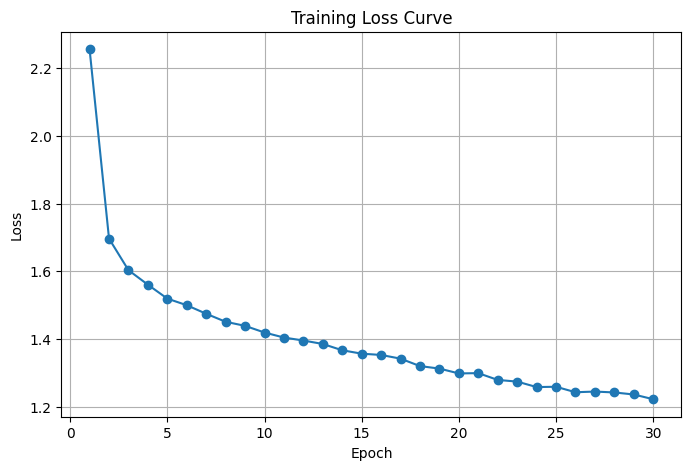

In [ ]:
import matplotlib.pyplot as plt  # Add at the top

epoch_losses = []  # Track average loss per epoch
val_metrics_per_epoch = {
    "CC": [], "KL": [], "SIM": [], "NSS": [], "AUC-Borji": []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(train_loader):
        images = batch_data["stimuli"].to(device)
        fdm = batch_data["fdm"].to(device)
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)
        pred_small = F.interpolate(pred_saliency, size=fdm.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(pred_small, fdm)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}", flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)  # Append to list
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)

# Plot after training
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

###Validation Plot Training

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists
epoch_losses = []  # Track training loss
val_metrics_per_epoch = {
    "CC": [], "KL": [], "SIM": [], "NSS": [], "AUC-Borji": []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, batch_data in enumerate(train_loader):
        images = batch_data["stimuli"].to(device)
        fdm = batch_data["fdm"].to(device)
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)
        pred_small = F.interpolate(pred_saliency, size=fdm.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(pred_small, fdm)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}", flush=True)

    # 🔹 After training for one epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Training Loss: {epoch_loss:.4f}", flush=True)

    # 🔹 Validation Evaluation
    val_metrics = evaluate_saliency_model(model, val_loader, device)
    for key in val_metrics:
        val_metrics_per_epoch[key].append(val_metrics[key])

Epoch [1/40], Batch [30/173] Loss: 1.6657
Epoch [1/40], Batch [60/173] Loss: 1.8539
Epoch [1/40], Batch [90/173] Loss: 1.6674
Epoch [1/40], Batch [120/173] Loss: 1.6428
Epoch [1/40], Batch [150/173] Loss: 1.5838
Epoch [1/40] Avg Training Loss: 1.6784
Average CC:         0.5421
Average KLDiv:      1.1601
Average Similarity: 0.4247
Average NSS:        2.6432
Average AUC-Borji:  0.9238
Epoch [2/40], Batch [30/173] Loss: 1.3048
Epoch [2/40], Batch [60/173] Loss: 1.5871
Epoch [2/40], Batch [90/173] Loss: 1.5650
Epoch [2/40], Batch [120/173] Loss: 1.4871
Epoch [2/40], Batch [150/173] Loss: 1.4535
Epoch [2/40] Avg Training Loss: 1.5922
Average CC:         0.5510
Average KLDiv:      1.1481
Average Similarity: 0.4425
Average NSS:        2.8759
Average AUC-Borji:  0.9262
Epoch [3/40], Batch [30/173] Loss: 1.6585
Epoch [3/40], Batch [60/173] Loss: 1.4926
Epoch [3/40], Batch [90/173] Loss: 1.8817
Epoch [3/40], Batch [120/173] Loss: 1.5473
Epoch [3/40], Batch [150/173] Loss: 1.6188
Epoch [3/40] Avg

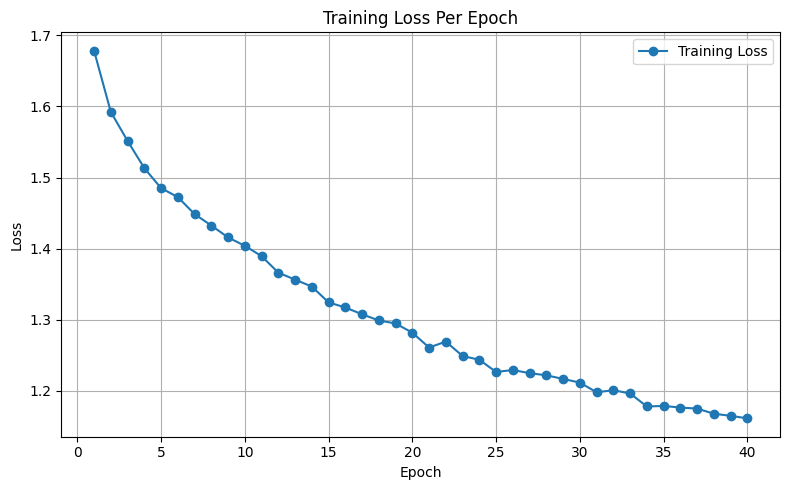

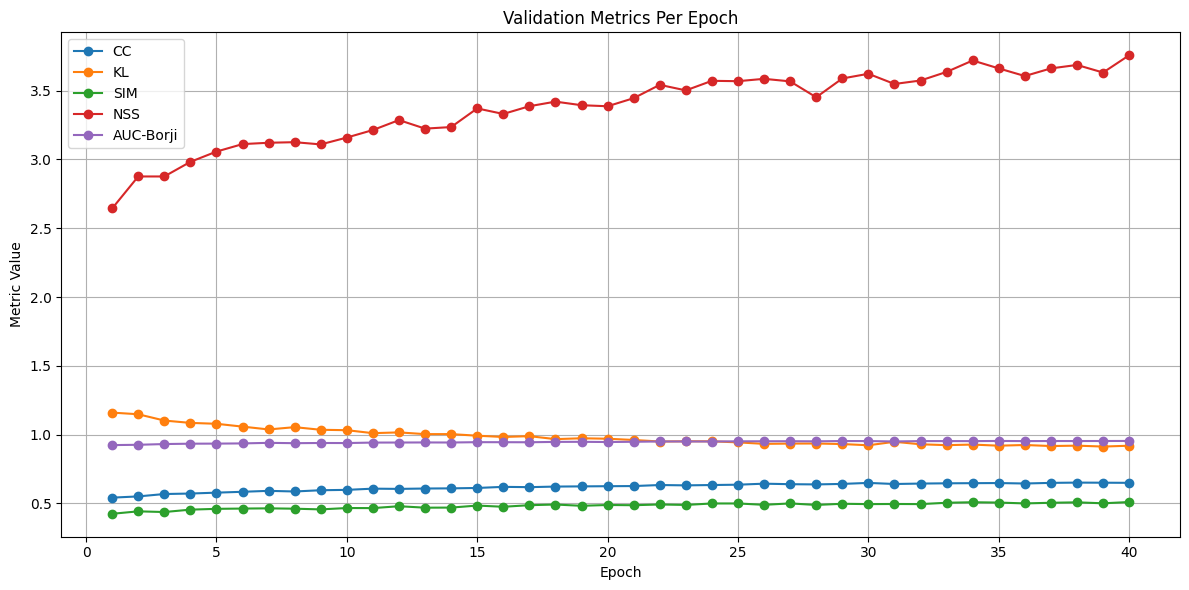

In [ ]:
epochs = range(1, num_epochs + 1)

# 🔹 1. Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, epoch_losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🔹 2. Plot Validation Metrics
plt.figure(figsize=(12, 6))
for metric in val_metrics_per_epoch:
    plt.plot(epochs, val_metrics_per_epoch[metric], marker='o', label=metric)

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics Per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Regular Training

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(train_loader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        fdm = batch_data["fdm"].to(device)           # [B, 1, H, W]
        # Task descriptions are returned as a list of strings
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)    # Forward pass using task descriptions
        pred_small = F.interpolate(
            pred_saliency,
            size=fdm.shape[-2:],          # (48, 48)
            mode='bilinear',
            align_corners=False
        )
        loss = criterion(pred_small, fdm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}", flush=True)
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)


Epoch [1/10], Batch [30/173] Loss: 2.4930
Epoch [1/10], Batch [60/173] Loss: 2.2115
Epoch [1/10], Batch [90/173] Loss: 2.2630
Epoch [1/10], Batch [120/173] Loss: 1.8057
Epoch [1/10], Batch [150/173] Loss: 1.5473
Epoch [1/10] Average Loss: 2.2526
Epoch [2/10], Batch [30/173] Loss: 1.4717
Epoch [2/10], Batch [60/173] Loss: 1.7233
Epoch [2/10], Batch [90/173] Loss: 1.8422
Epoch [2/10], Batch [120/173] Loss: 1.6973
Epoch [2/10], Batch [150/173] Loss: 1.6525
Epoch [2/10] Average Loss: 1.7021
Epoch [3/10], Batch [30/173] Loss: 1.6211
Epoch [3/10], Batch [60/173] Loss: 1.5138
Epoch [3/10], Batch [90/173] Loss: 1.6462
Epoch [3/10], Batch [120/173] Loss: 1.5330
Epoch [3/10], Batch [150/173] Loss: 1.4598
Epoch [3/10] Average Loss: 1.6005
Epoch [4/10], Batch [30/173] Loss: 1.5602
Epoch [4/10], Batch [60/173] Loss: 1.7659
Epoch [4/10], Batch [90/173] Loss: 1.5155
Epoch [4/10], Batch [120/173] Loss: 1.5142
Epoch [4/10], Batch [150/173] Loss: 1.3656
Epoch [4/10] Average Loss: 1.5587
Epoch [5/10], Ba

In [ ]:
# Full Dataset (Test Set) Evaluation Cell

import torch
import torch.nn.functional as F

# Make sure your model is in evaluation mode
model.eval()

# Lists to accumulate predictions and ground truths
all_preds = []
all_gts   = []

# Iterate through the test_loader and move predictions and ground truths to CPU
with torch.no_grad():
    for batch_data in test_loader:
        images    = batch_data["stimuli"].to(device)          # [B, 3, H, W]
        gts       = batch_data["fdm"].to(device)              # [B, 1, H, W]
        task_desc = batch_data["task_description"]            # list of strings

        # Forward pass through the model
        preds = model(images, task_desc)                      # [B, 1, h’, w’]

        # Resize predictions to match ground‐truth resolution
        preds = F.interpolate(
            preds,
            size=gts.shape[-2:],                              # (H, W)
            mode='bilinear',
            align_corners=False
        )

        # Move to CPU and store
        all_preds.append(preds.cpu())
        all_gts.append(gts.cpu())

# Concatenate all batches
full_preds = torch.cat(all_preds, dim=0)  # [N, 1, H, W]
full_gts   = torch.cat(all_gts,   dim=0)  # [N, 1, H, W]

# Compute loss over the entire test set
full_loss = criterion(full_preds.to(device), full_gts.to(device))
print(f"Test Set Loss: {full_loss.item():.4f}")

Full Dataset Loss: 1.7164


### Save the model

In [ ]:
import os

# Path to your models folder inside TDSP
models_dir = "/content/drive/MyDrive/TDSP/models"
# Create the folder if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Full path where you want to save your model
save_path = os.path.join(models_dir, "tdsp_40epoch.pth")

# Save the model state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/TDSP/models/tdsp_40epoch.pth


## Inference


### Inference of the most recent model on the test dataset.

In [ ]:
import random, os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_random_test_sample(model_path: str):
    """
    Loads YOLOTaskSaliencyModel from model_path, picks a random image from test_ds,
    runs it through the model for all 4 tasks, and plots predictions vs GT.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 1) Load model
    model = YOLOTaskSaliencyModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 2) Pick a random test‐split sample and get its base filename
    rand_subset_idx = random.randint(0, len(test_ds) - 1)
    orig_idx        = test_ds.indices[rand_subset_idx]
    _, fdm_path, _  = dataset.samples[orig_idx]
    base_name       = os.path.splitext(os.path.basename(fdm_path))[0]

    # 3) Find all four views of that image in the full dataset
    matched_idxs = [
        i
        for i, (_, fdm_p, _) in enumerate(dataset.samples)
        if os.path.splitext(os.path.basename(fdm_p))[0] == base_name
    ]
    assert len(matched_idxs) == 4, f"Expected 4 views for {base_name}, got {len(matched_idxs)}"

    # 4) Build a mini‐batch
    samples      = [dataset[i] for i in matched_idxs]
    images_batch = torch.stack([s["stimuli"]          for s in samples], dim=0).to(device)  # [4,3,H,W]
    fdm_batch    = torch.stack([s["fdm"]              for s in samples], dim=0)          # [4,1,H,W]
    descs        = [s["task_description"] for s in samples]                              # 4 strings

    # 5) Inference + resize
    with torch.no_grad():
        preds = model(images_batch, descs)
        preds = F.interpolate(
            preds,
            size=fdm_batch.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

    # 6) To NumPy & plot
    pred_np = preds.cpu().numpy()  # [4,1,H,W]
    gt_np   = fdm_batch.numpy()    # [4,1,H,W]

    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    for i in range(4):
        axes[0,i].imshow(pred_np[i,0], cmap="gray")
        axes[0,i].set_title(f"Predicted\n{descs[i]}")
        axes[0,i].axis("off")

        axes[1,i].imshow(gt_np[i,0], cmap="gray")
        axes[1,i].set_title("Ground Truth")
        axes[1,i].axis("off")

    fig.suptitle(f"Random test image: {base_name}\nModel: {os.path.basename(model_path)}", y=1.02)
    plt.tight_layout()
    plt.show()

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



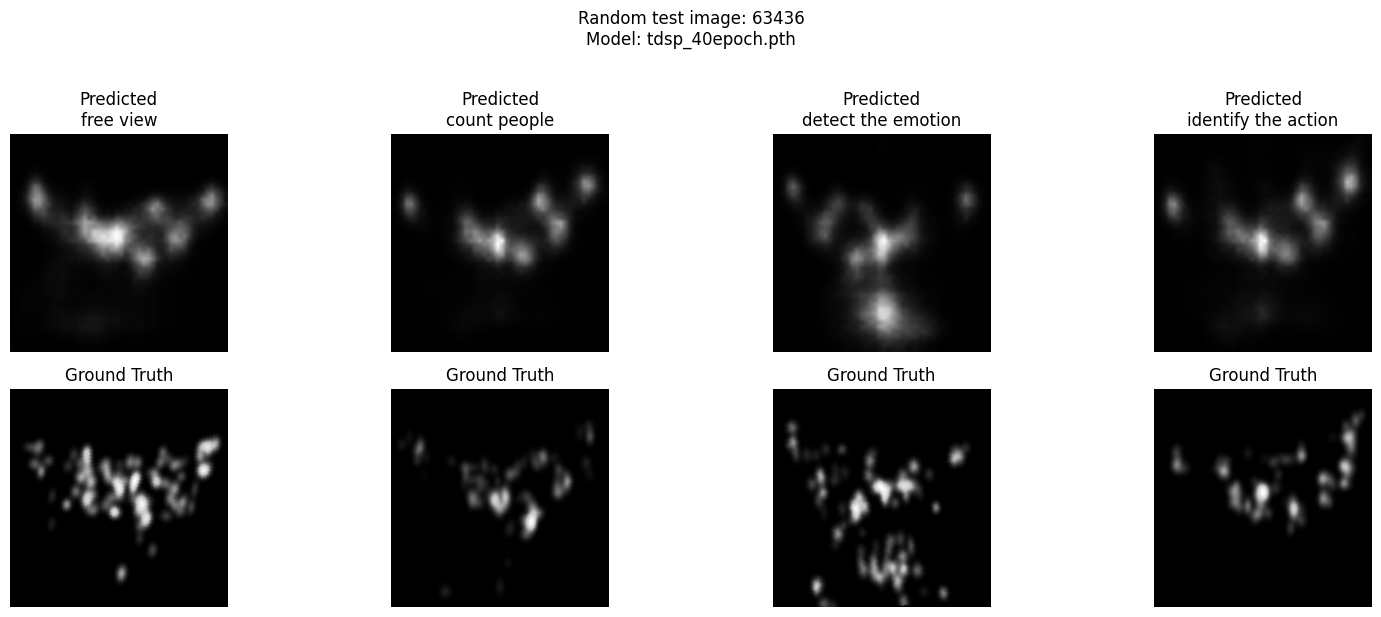

In [ ]:
model_path = "/content/drive/MyDrive/TDSP/models/tdsp_40epoch.pth"
visualize_random_test_sample(model_path)

### Inference of Model Performance on N different images for each task

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


--- Generating panel #1 for test_ds index 26 → /content/drive/MyDrive/TDSP/images/panel_1.png ---


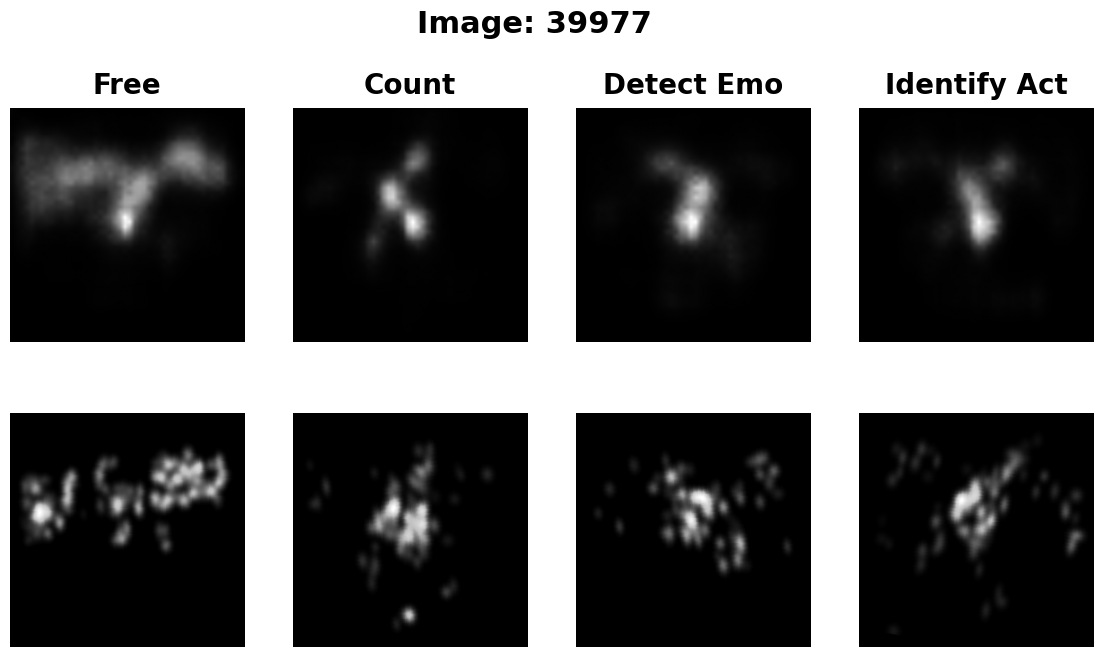


--- Generating panel #2 for test_ds index 137 → /content/drive/MyDrive/TDSP/images/panel_2.png ---


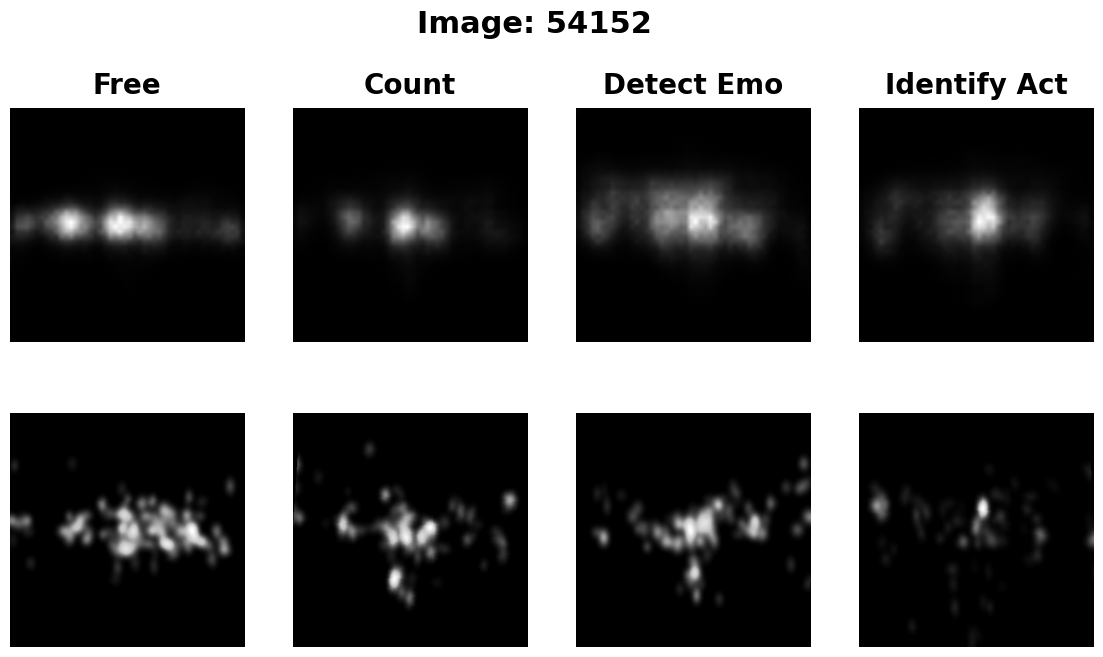


--- Generating panel #3 for test_ds index 44 → /content/drive/MyDrive/TDSP/images/panel_3.png ---


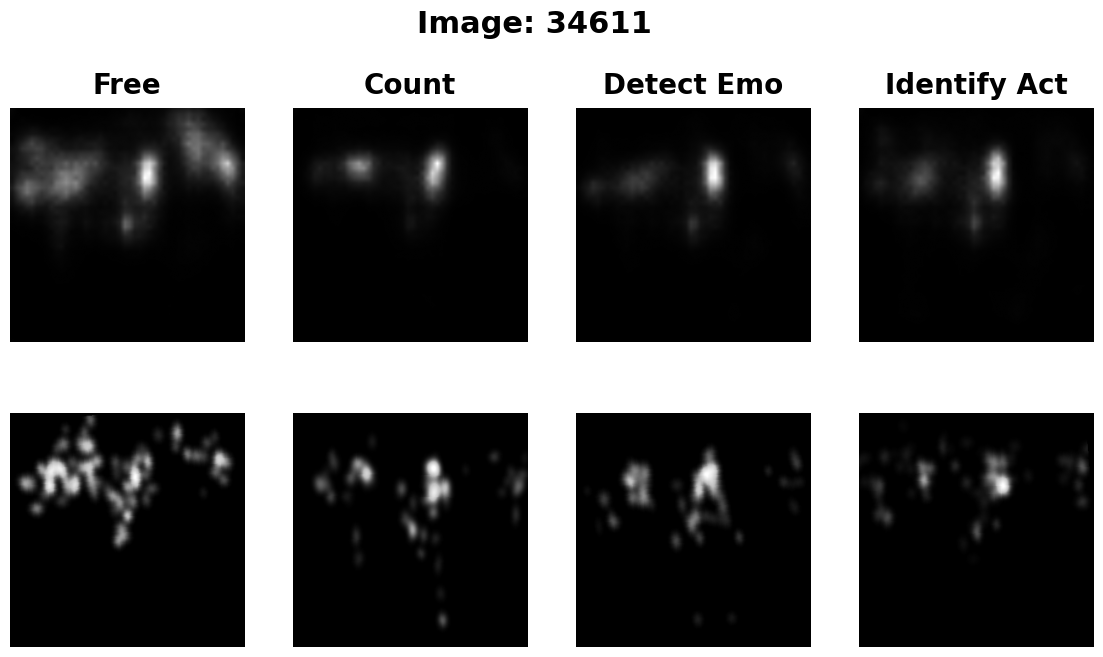


--- Generating panel #4 for test_ds index 208 → /content/drive/MyDrive/TDSP/images/panel_4.png ---


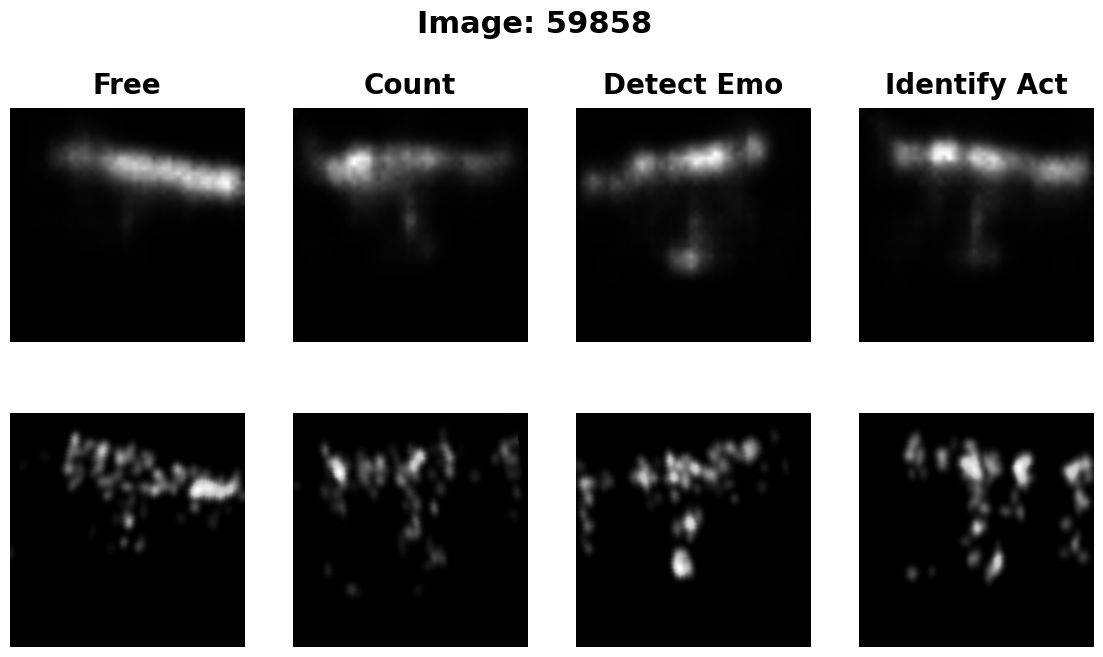


--- Fusing the four panels into one 2×2 image ---


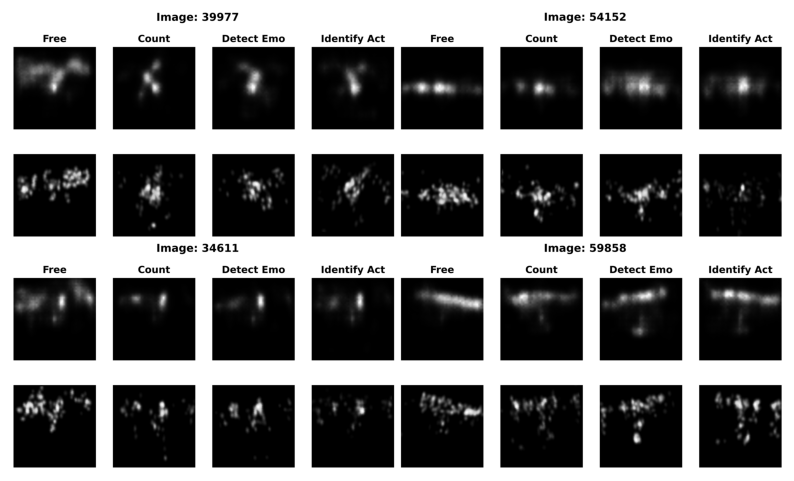

In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# -----------------------------------------------------------------------------
# 1) Mount Drive (if you haven't already)
# -----------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------------------------------------
# 2) Define paths
# -----------------------------------------------------------------------------
base_dir   = "/content/drive/MyDrive/TDSP/images"
model_path = "/content/drive/MyDrive/TDSP/models/tdsp_40epoch.pth"
os.makedirs(base_dir, exist_ok=True)

# -----------------------------------------------------------------------------
# 3) Assume `dataset` and `test_ds` already exist in this session
# -----------------------------------------------------------------------------
#    (For example, you ran your TaskSaliencyDataset and built test_ds earlier.)
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 4) Revised function: save one 2×4 panel with very short titles
# -----------------------------------------------------------------------------
def save_2x4_panel_short_titles(
    model,
    dataset,
    test_ds,
    subset_idx,
    out_filepath,
    figsize=(14, 7)
):
    """
    Generates a 2×4 grid for one test image using SHORT column headers:
      • “Free” (free view)
      • “Count” (count people)
      • “Detect Emo” (detect the emotion)
      • “Identify Act” (identify the action)

    Saves to out_filepath and displays inline.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # a) Find the dataset index for this test‐subset index
    global_idx = test_ds.indices[subset_idx]
    _, fdm_path, _ = dataset.samples[global_idx]
    base_name = os.path.splitext(os.path.basename(fdm_path))[0]

    # b) Locate the four “task‐views” sharing this base_name
    matched = [
        idx for idx, (_, fdm_p, _) in enumerate(dataset.samples)
        if os.path.splitext(os.path.basename(fdm_p))[0] == base_name
    ]
    if len(matched) != 4:
        raise RuntimeError(f"Expected 4 task‐views for '{base_name}', but found {len(matched)}")

    # c) Map from full text description → dataset index
    desc_to_idx = {dataset[i]["task_description"]: i for i in matched}

    # d) Define the (full → short) mapping
    full_to_short = {
        "free view":       "Free",
        "count people":    "Count",
        "detect the emotion": "Detect Emo",
        "identify the action": "Identify Act"
    }

    # e) Define the exact order of the four full descriptions
    task_order_full = ["free view", "count people", "detect the emotion", "identify the action"]
    task_order_short = [full_to_short[f] for f in task_order_full]

    # f) Reorder dataset indices according to full descriptions
    ordered_indices = [desc_to_idx[f] for f in task_order_full]
    ordered_samples = [dataset[i] for i in ordered_indices]

    # g) Stack stimuli and GT in that order
    imgs_tensor = torch.stack([s["stimuli"] for s in ordered_samples], dim=0).to(device)  # [4,3,H,W]
    gt_tensor   = torch.stack([s["fdm"]     for s in ordered_samples], dim=0)            # [4,1,H,W]
    # descs_full = [s["task_description"] for s in ordered_samples]   # not strictly needed now

    # h) Forward‐pass and interpolate to ground‐truth size
    with torch.no_grad():
        preds = model(imgs_tensor, task_order_full)  # [4,1,h',w']
        preds = F.interpolate(
            preds,
            size=gt_tensor.shape[-2:],  # (H, W)
            mode="bilinear",
            align_corners=False
        )
    pred_np = preds.cpu().numpy()  # [4,1,H,W]
    gt_np   = gt_tensor.numpy()    # [4,1,H,W]

    # i) Create a 2×4 grid with reduced whitespace
    fig, axes = plt.subplots(
        2, 4,
        figsize=figsize,
        gridspec_kw={"wspace": 0.2, "hspace": 0.3}
    )

    # j) Plot each column
    for col_i in range(4):
        # Predicted row
        ax_pred = axes[0, col_i]
        ax_pred.imshow(pred_np[col_i, 0], cmap="gray")
        ax_pred.axis("off")
        ax_pred.set_title(
            task_order_short[col_i],   # e.g. “Free”, “Count”, “Detect Emo”, “Identify Act”
            fontsize=20,
            fontweight="bold",
            pad=10
        )

        # Ground Truth row
        ax_gt = axes[1, col_i]
        ax_gt.imshow(gt_np[col_i, 0], cmap="gray")
        ax_gt.axis("off")

    # k) Label the left side of each row with larger fonts
    axes[0, 0].set_ylabel(
        "Predicted",
        fontsize=18,
        fontweight="bold",
        rotation=0,
        labelpad=30
    )
    axes[1, 0].set_ylabel(
        "Ground Truth",
        fontsize=18,
        fontweight="bold",
        rotation=0,
        labelpad=30
    )

    # l) Suptitle for this image
    fig.suptitle(
        f"Image: {base_name}",
        fontsize=22,
        fontweight="bold",
        y=1.02
    )

    # m) Save & display
    os.makedirs(os.path.dirname(out_filepath), exist_ok=True)
    fig.savefig(out_filepath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# -----------------------------------------------------------------------------
# 5) Function to fuse four short‐titled panels into one 2×2 image (no extra margin)
# -----------------------------------------------------------------------------
def fuse_panels_2x2(panel_paths, out_path="all_in_one_2x2.png"):
    """
    Given 4 file paths to the previously saved 2×4‐grid PNGs (with short titles),
    fuses them in a simple 2×2 layout (no extra padding), saves to out_path, and displays.
    """
    imgs = [Image.open(p) for p in panel_paths]

    # Verify they all share the same w×h
    w, h = imgs[0].size
    for i, im in enumerate(imgs):
        if im.size != (w, h):
            raise ValueError(f"Panel '{panel_paths[i]}' is size {im.size}, expected ({w},{h}).")

    # Create a new white canvas of size (2w × 2h)
    combined = Image.new("RGB", (w * 2, h * 2), (255, 255, 255))

    # Paste each panel into its quadrant, with no extra margin
    combined.paste(imgs[0], (0,   0))  # top-left
    combined.paste(imgs[1], (w,   0))  # top-right
    combined.paste(imgs[2], (0,   h))  # bottom-left
    combined.paste(imgs[3], (w,   h))  # bottom-right

    # Save & display inline
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    combined.save(out_path, dpi=(300, 300))
    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis("off")
    plt.show()


# -----------------------------------------------------------------------------
# 6) Main execution: generate 4 short‐titled panels, fuse & display
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # a) Load your model once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = YOLOTaskSaliencyModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # b) Randomly pick 4 distinct indices from test_ds
    random.seed(123)
    chosen_idxs = random.sample(range(len(test_ds)), 4)

    # c) Create and save each 2×4 panel with short titles
    panel_files = []
    for i, subset_idx in enumerate(chosen_idxs, start=1):
        panel_fname = os.path.join(base_dir, f"panel_{i}.png")
        print(f"\n--- Generating panel #{i} for test_ds index {subset_idx} → {panel_fname} ---")
        save_2x4_panel_short_titles(
            model=model,
            dataset=dataset,
            test_ds=test_ds,
            subset_idx=subset_idx,
            out_filepath=panel_fname,
            figsize=(14, 7)
        )
        panel_files.append(panel_fname)

    # d) Fuse the four short‐titled panels into one 2×2 image (no extra spacing)
    fused_path = os.path.join(base_dir, "all_in_one_2x2.png")
    print("\n--- Fusing the four panels into one 2×2 image ---")
    fuse_panels_2x2(panel_files, out_path=fused_path)

### Evaluate model performance

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score

def correlation_coefficient(pred: torch.Tensor, gt: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    Pearson’s correlation between two maps of shape [H, W].
    """
    p = pred.view(-1)
    g = gt.view(-1)
    p_mean = p.mean()
    g_mean = g.mean()
    num = ((p - p_mean) * (g - g_mean)).sum()
    den = torch.sqrt(((p - p_mean)**2).sum() * ((g - g_mean)**2).sum()).clamp(min=eps)
    return num / den

def kl_divergence(pred: torch.Tensor, gt: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    KL divergence treating each map as a discrete PDF over H×W.
    """
    # normalize
    p = pred.clamp(min=0)  # ensure non-negative
    p = p / (p.sum() + eps)
    g = gt / (gt.sum() + eps)
    return (g * torch.log((g + eps) / (p + eps))).sum()

def nss_score(pred: torch.Tensor, fixation_map: torch.Tensor) -> float:
    pred = pred.view(-1).cpu().numpy()
    fixation = fixation_map.view(-1).cpu().numpy()
    if fixation.sum() == 0:
        return float("nan")
    pred = (pred - pred.mean()) / (pred.std() + 1e-8)
    return np.mean(pred[fixation > 0])

def similarity_score(pred: torch.Tensor, gt: torch.Tensor) -> float:
    p = pred.view(-1)
    g = gt.view(-1)
    p = p / (p.sum() + 1e-8)
    g = g / (g.sum() + 1e-8)
    return torch.min(p, g).sum().item()

def auc_borji(pred: torch.Tensor, fixation_map: torch.Tensor, n_splits=100) -> float:
    pred = pred.view(-1).cpu().numpy()
    fixation = fixation_map.view(-1).cpu().numpy()
    if fixation.sum() == 0:
        return float("nan")
    sal_fix = pred[fixation > 0]
    sal_nonfix = pred[fixation == 0]

    if len(sal_nonfix) == 0:
        return float("nan")

    aucs = []
    for _ in range(n_splits):
        sampled_neg = np.random.choice(sal_nonfix, size=len(sal_fix), replace=False)
        labels = np.concatenate([np.ones(len(sal_fix)), np.zeros(len(sampled_neg))])
        scores = np.concatenate([sal_fix, sampled_neg])
        aucs.append(roc_auc_score(labels, scores))
    return np.mean(aucs)

In [ ]:
def evaluate_saliency_model(model, loader, device):
    """
    Runs the model on every batch in `loader`, computes CC, KLD, NSS, SIM, AUC-Borji per-sample,
    and returns their averages.
    """
    model.to(device).eval()
    cc_list, kld_list = [], []
    nss_list, sim_list, auc_list = [], [], []

    with torch.no_grad():
        for batch in loader:
            imgs = batch["stimuli"].to(device)
            gts  = batch["fdm"].to(device)
            descs = batch["task_description"]

            preds = model(imgs, descs)
            preds = F.interpolate(preds, size=gts.shape[-2:], mode='bilinear', align_corners=False)

            B = preds.size(0)
            for i in range(B):
                pred = preds[i, 0]
                gt = gts[i, 0]
                fix_map = (gt > 0.5).float()  # binary fixation map

                cc_list.append(correlation_coefficient(pred, gt).item())
                kld_list.append(kl_divergence(pred, gt).item())
                sim_list.append(similarity_score(pred, gt))
                nss_list.append(nss_score(pred, fix_map))
                auc_list.append(auc_borji(pred, fix_map))

    # Compute averages
    avg_cc  = sum(cc_list)  / len(cc_list)  if cc_list else float("nan")
    avg_kld = sum(kld_list) / len(kld_list) if kld_list else float("nan")
    avg_sim = sum(sim_list) / len(sim_list) if sim_list else float("nan")
    avg_nss = sum(nss_list) / len(nss_list) if nss_list else float("nan")
    avg_auc = sum(auc_list) / len(auc_list) if auc_list else float("nan")

    print(f"Average CC:         {avg_cc:.4f}")
    print(f"Average KLDiv:      {avg_kld:.4f}")
    print(f"Average Similarity: {avg_sim:.4f}")
    print(f"Average NSS:        {avg_nss:.4f}")
    print(f"Average AUC-Borji:  {avg_auc:.4f}")

    return {
        "CC": avg_cc, "KL": avg_kld,
        "SIM": avg_sim, "NSS": avg_nss, "AUC-Borji": avg_auc
    }

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/TDSP/models/tdsp_40epoch.pth"))
metrics = evaluate_saliency_model(model, test_loader, device)

Average CC:         0.6433
Average KLDiv:      0.9239
Average Similarity: 0.5112
Average NSS:        3.5290
Average AUC-Borji:  0.9489
